In [2]:
import os
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

data_dir = Path("data/PlantVillage")
classes = [d.name for d in data_dir.iterdir() if d.is_dir()]

print("Number of classes:", len(classes))

class_counts = {cls : len(list((data_dir/cls).glob("*.jpg"))) for cls in classes}
for cls, count in class_counts.items():
    print(cls, count)


Number of classes: 15
Pepper__bell___Bacterial_spot 997
Pepper__bell___healthy 1477
Potato___Early_blight 1000
Potato___healthy 152
Potato___Late_blight 1000
Tomato_Bacterial_spot 2127
Tomato_Early_blight 1000
Tomato_healthy 1591
Tomato_Late_blight 1908
Tomato_Leaf_Mold 952
Tomato_Septoria_leaf_spot 1771
Tomato_Spider_mites_Two_spotted_spider_mite 1676
Tomato__Target_Spot 1404
Tomato__Tomato_mosaic_virus 373
Tomato__Tomato_YellowLeaf__Curl_Virus 3208


{'Potato___healthy': 152, 'Tomato__Tomato_mosaic_virus': 373, 'Tomato_Leaf_Mold': 952, 'Pepper__bell___Bacterial_spot': 997, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Tomato_Early_blight': 1000, 'Tomato__Target_Spot': 1404, 'Pepper__bell___healthy': 1477, 'Tomato_healthy': 1591, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Late_blight': 1908, 'Tomato_Bacterial_spot': 2127, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208}


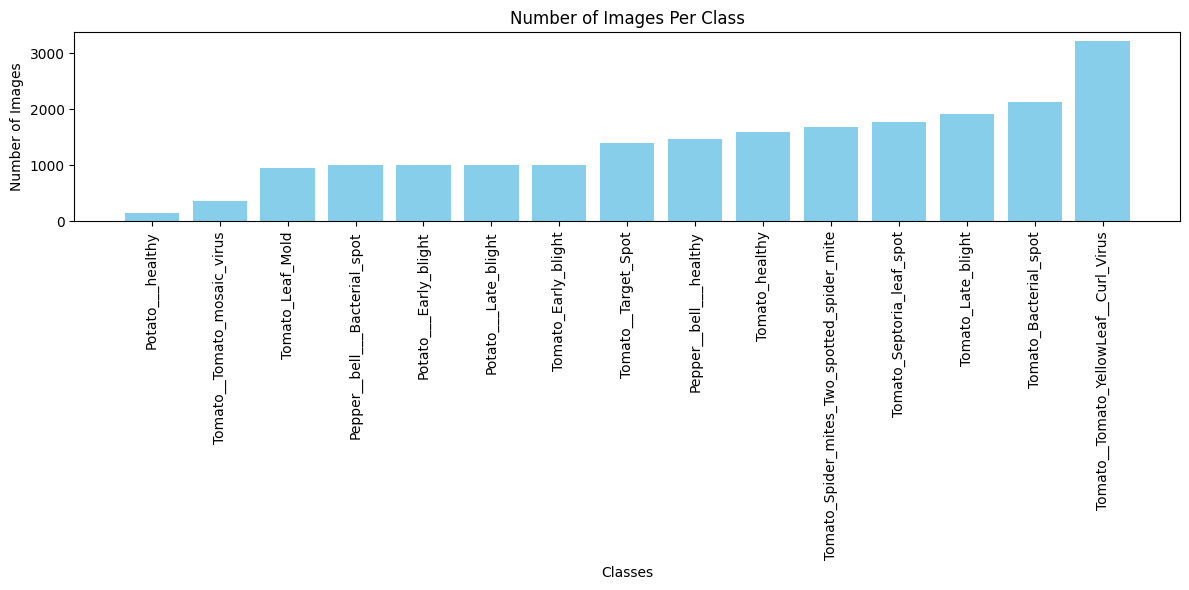

In [3]:
#Creating the bar chart for the number of images in each class
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda cls: cls[1]))
print(sorted_class_counts)


labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images Per Class")
plt.tight_layout()
plt.show()

#It can be seen that there is quite an imbalance in the number of images in each class

In [4]:
#Inspecting image resolutions

image_paths = list((data_dir).glob("*/*.jpg"))
resolutions = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        resolutions.append(img.size)



In [8]:
#New cell so the above doesn't have to be run again
res_count = Counter(resolutions)
print(res_count)
print("Unique resolutions:", len(res_count))

#All the images are of the same resolution, 256x256 px

Counter({(256, 256): 20636})
Unique resolutions: 1


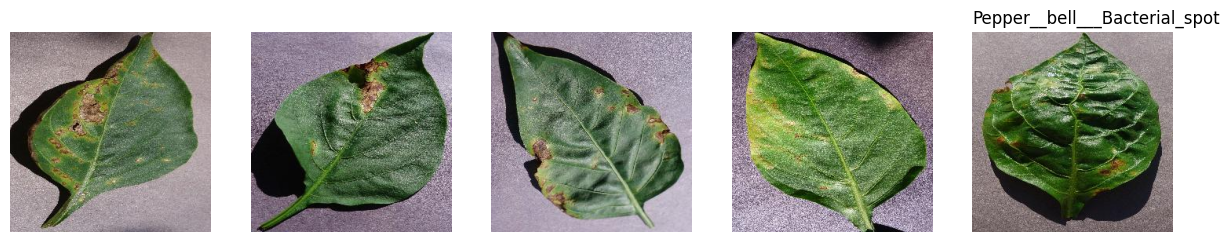

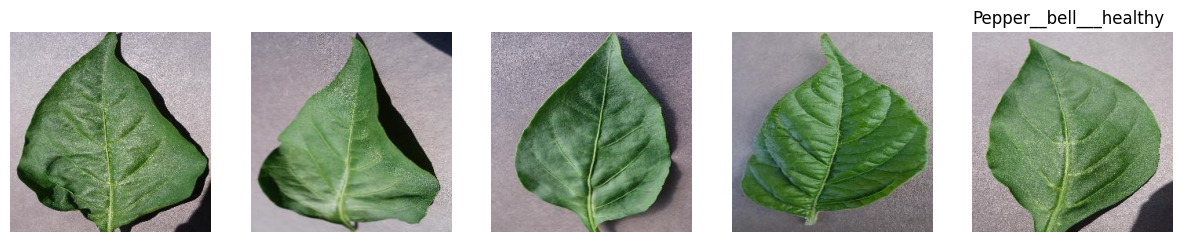

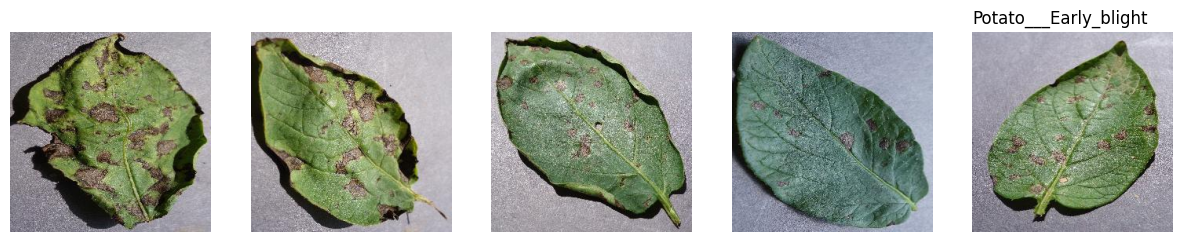

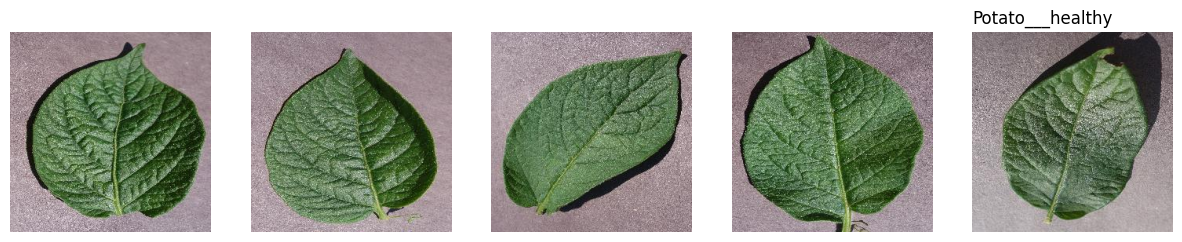

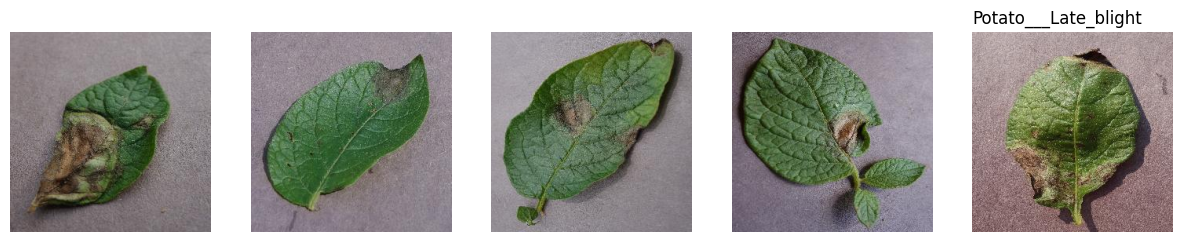

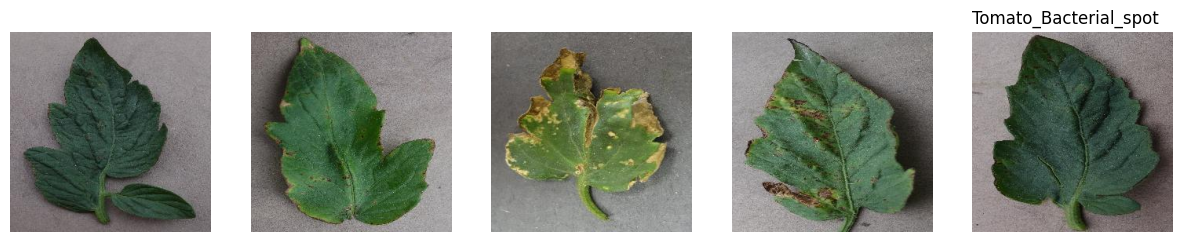

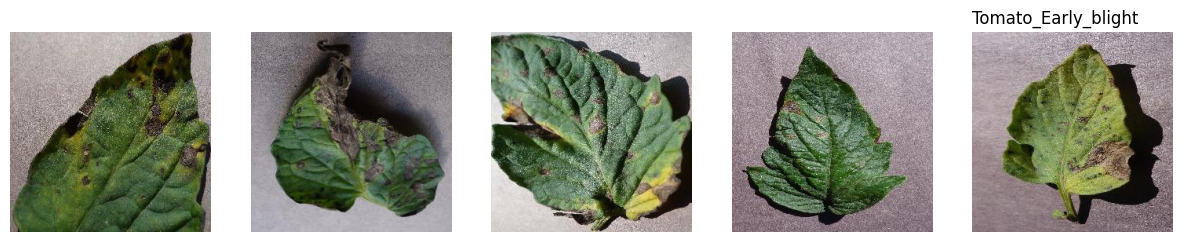

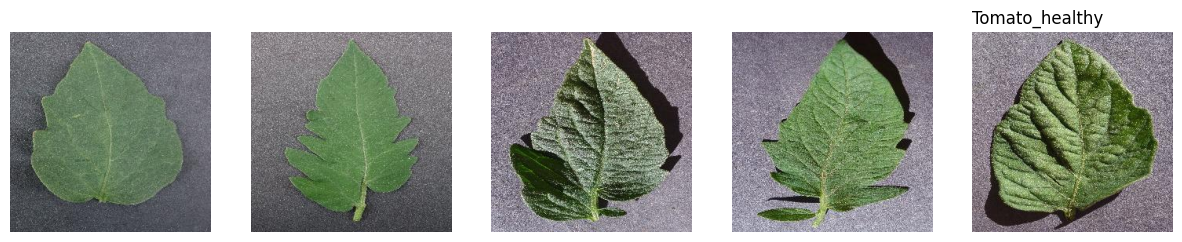

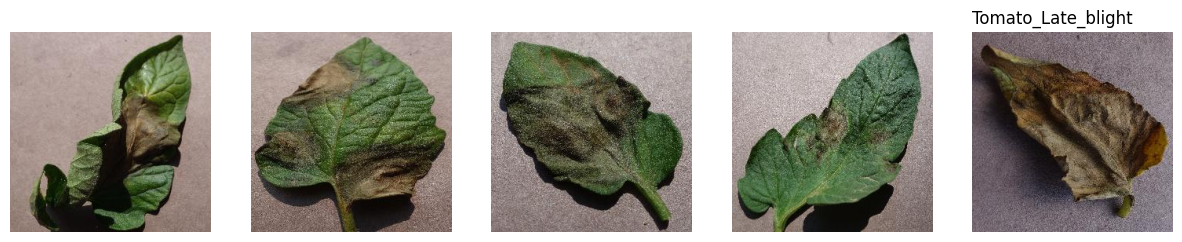

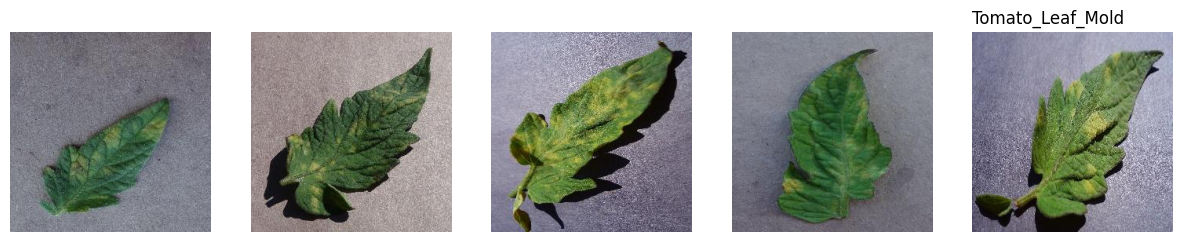

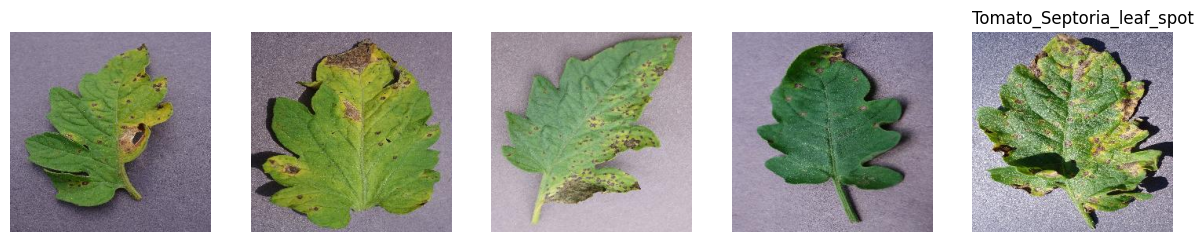

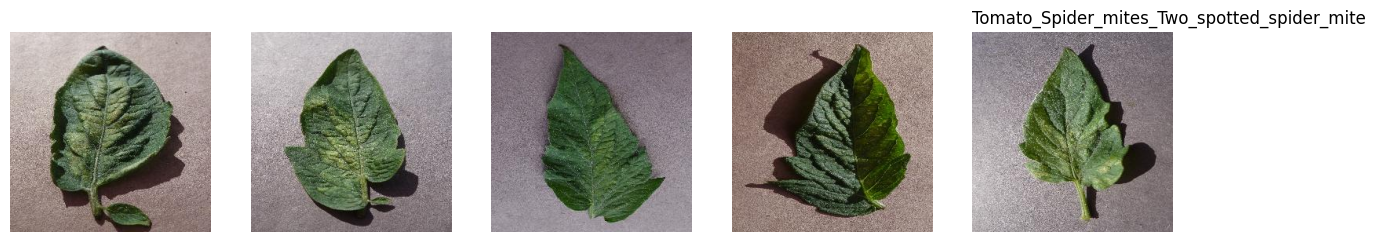

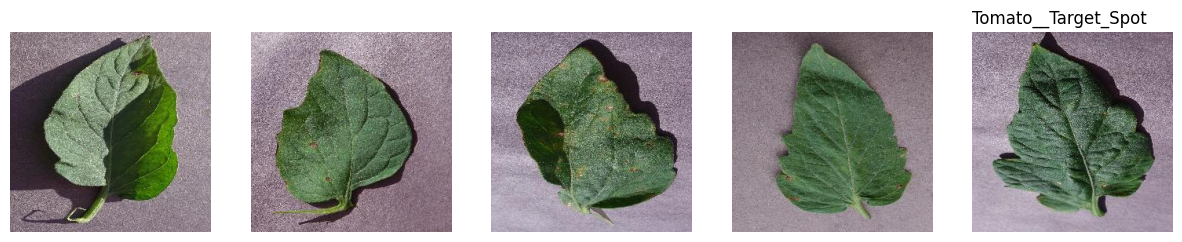

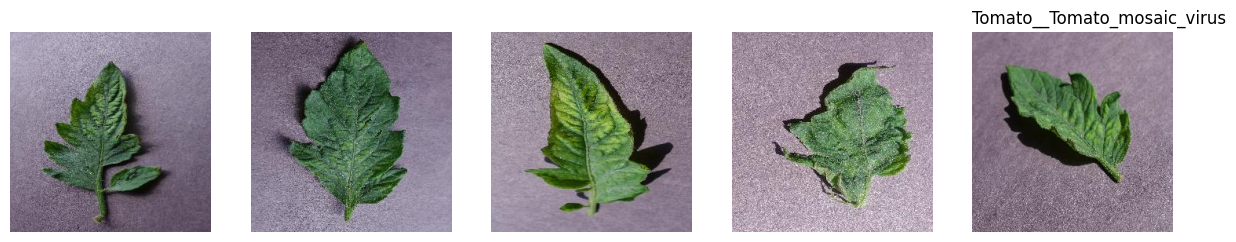

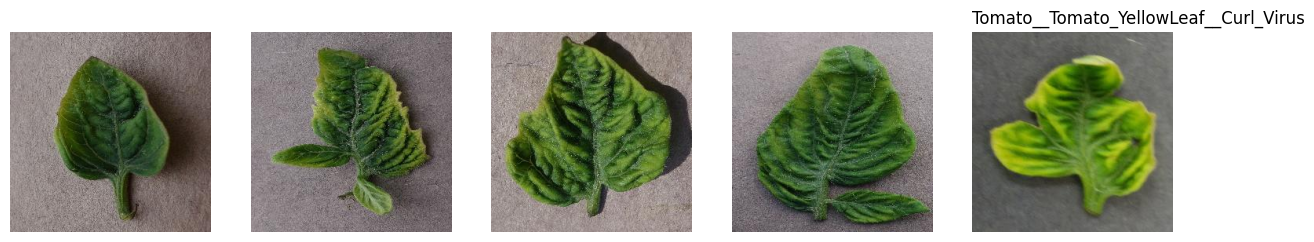

In [55]:
#Showing some sample images of each class
for cls in classes:
    sample_images = list((data_dir/cls).glob("*.jpg"))[:5]
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    plt.title(cls, loc='left')
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis("off")

In [18]:
#Transforming images

from torchvision import transforms

transform_pipeline = transforms.Compose([
    #All images are already 256x256 but this is good practice
    transforms.Resize(256),

    #Want to centre crop to 224 as that is the optimal size for ResNet18
    transforms.CenterCrop(224),
    
    #Random augmentations
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    transforms.ToTensor(),

    #Normalizing images using ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




In [21]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

dataset = ImageFolder(root="data/PlantVillage", transform=transform_pipeline)

#Splitting dataset into training set and validation set
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

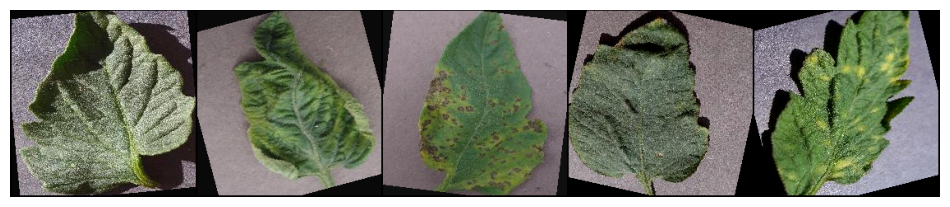

In [32]:
#Visualizing the transformations
import torch, torchvision
images, labels = next(iter(train_loader))

#undo_normalize = transforms.Compose([
#    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[1., 1., 1.])
#])

undo_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)

images = torch.stack([undo_normalize(img) for img in images])

grid = torchvision.utils.make_grid(images[:5], nrow=5)
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0))  # convert from C,H,W to H,W,C
plt.axis("off")
plt.show()